In [1]:
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import os
import illustris_python as il
import warnings

### Basic selection selection criteria

In [2]:
halo_min_log = 12     # lower mass limit of halo
frac_circ = 0.5       # fraction of stellar mass in galaxy disc for it to be considered late-type
ssfr_thresh  = 1e-11  # threshold specific SFR for a galaxy to be considered star-forming (see Donnari+2019,2021)
min_hi_frac = 0.3     # threshold of atomic gas fraction for star-forming galaxies

### 0.2 define paths and fields of interest

In [3]:
basePath = './fof_subhalo_z0/'  ### groupcat data files are in basePath/groups_099/
halo_fields = ['GroupFirstSub','GroupNsubs','Group_M_Mean200'] ### Halo fields of interest. Options for halo mass: 'Group_M_Mean200', 'Group_M_TopHat200', 'Group_M_Crit200', 'Group_M_Crit500'
subhalo_fields = ['SubhaloFlag','SubhaloMass','SubhaloGrNr','SubhaloMassInRadType','SubhaloGasMetalFractions'] ### Subhalo fields. 'SubhaloMassInRadType' OR 'SubhaloMassInHalfRadType'
HI_column = 'm_hi_GD14_map' ### column of HI mass used; options are: 'm_hi_GD14_map', 'm_hi_GD14_vol', 'm_hi_GK11_map', 'm_hi_GK11_vol', 'm_hi_K13_map', 'm_hi_K13_vol', 'm_hi_L08_map', 'm_hi_S14_map', 'm_hi_S14_vol'

### 0.3 load data for haloes and subhaloes

In [4]:
halos = il.groupcat.loadHalos(basePath,99,fields=halo_fields)
halos_id = np.arange(halos['count'])
subhalos = il.groupcat.loadSubhalos(basePath,99,fields=subhalo_fields)
h = il.groupcat.loadHeader(basePath, 99)['HubbleParam']
f_h1h2 = h5py.File('hih2_galaxy_099.hdf5','r')

### 0.4 load angular momentum and star formation tables

In [5]:
### Ang. momentum
jtable = h5py.File('stellar_circs.hdf5')['Snapshot_99']
id_j = np.array(jtable['SubfindID'])
circ = np.array(jtable['CircAbove07Frac'])  ### fraction of stellar mass in galaxy disc
### SFR
sfrtable = h5py.File('star_formation_rates.hdf5')['Snapshot_99']
id_sfr = np.array(sfrtable['SubfindID'])
sfr =  np.array(sfrtable['SFR_MsunPerYrs_in_InRad_1000Myrs'])
### print stats
print('Number of galaxies in ang. mom. table:',id_j.size)
print('Number of galaxies in SFR table:      ',id_sfr.size)

Number of galaxies in ang. mom. table: 7904
Number of galaxies in SFR table:       19974


##### 0.4.1 select late-type galaxies based on stellar mass in disc
##### (based on Tacchella+2019 https://ui.adsabs.harvard.edu/abs/2019MNRAS.487.5416T/abstract)

In [6]:
id_lt = id_j[circ>frac_circ] ### IDs of late-type galaxies
print('Number of late type galaxies: %d\nNumber of early type galaxies: %d' %(id_lt.size, id_j.size-id_lt.size))

Number of late type galaxies: 893
Number of early type galaxies: 7011


##### 0.4.2 select late-type galaxies based on star specific SFR (sSFR)
##### (based on Donnari+2019 https://ui.adsabs.harvard.edu/abs/2019MNRAS.485.4817D/abstract and references therein)

In [7]:
mstar_sfr = np.take(np.array(subhalos['SubhaloMassInRadType'][:,4]), id_sfr) * 1e10 / h
ssfr = sfr / mstar_sfr
sf_ssfr = ssfr[ssfr>ssfr_thresh]
sf_ids  = id_sfr[ssfr>ssfr_thresh]
print('Number of star-forming galaxies (excluding gas fraction criteria):',sf_ids.size)

Number of star-forming galaxies: 12346


# Method 1: using HI masses from h1h2 catalog

#### 1.1 Get IDs of primary subhaloes from the gas supplementary catalog, then return the HI mass of those primary (central) subhaloes

In [8]:
flag = np.array(f_h1h2['is_primary'])
id_gas = np.array(f_h1h2['id_subhalo']).astype(np.int32)
id_gas_p = np.array(id_gas[np.where(flag==1.0)]).astype(np.int32)
grpid_gas = np.array(f_h1h2['id_group']).astype(np.int32)
grpid_gas_p = np.array(grpid_gas[np.where(flag==1.0)]).astype(np.int32)
m_h1_p = np.array(f_h1h2[HI_column][np.where(flag==1.0)]).astype(np.float32)

#### 1.2 proceed to select the primary subhaloes in the `subhalos` array 

In [9]:
sub_id = subhalos['SubhaloGrNr'][id_gas_p]
gal_mass_hi = m_h1_p
gal_tot_mass = subhalos['SubhaloMass'][id_gas_p]
gal_mass_rad = subhalos['SubhaloMassInRadType'][id_gas_p]

##### 1.2.1 Selecting late types based on ang. mom. table

In [10]:
id_circ_lt = np.intersect1d(sub_id, id_lt)
print('Number of late types (based on disk stellar mass criteria) with available gas masses:',id_circ_lt.size)

Number of late types with available gas masses: 1


#### 1.3 convert masses into adequate units

In [11]:
gal_mass_gas  = gal_mass_rad[:,0] * 1e10 / h
gal_mass_dm   = gal_mass_rad[:,1] * 1e10 / h               # total mass of all DM particles in the subhalo
gal_mass_star = gal_mass_rad[:,4] * 1e10 / h
halo_m200 = halos['Group_M_Mean200'][grpid_gas_p] * 1e10 / h  # M200 of parent halo

###### (Note: 0 = gas, 1 = DM, 2 unused, 3 = tracers, 4 = stars, 5 = BHs)

##### 1.3.1 Selecting late types based on SFR and atomic gas fraction

In [12]:
hi_frac = 1.35*gal_mass_hi / (1.35*gal_mass_hi + gal_mass_star)
high_hi_frac = hi_frac[hi_frac>min_hi_frac]
id_high_hi = id_gas_p[hi_frac>min_hi_frac]
id_sfr_lt, ind_sfr, ind_gas = np.intersect1d(sf_ids, id_high_hi, return_indices=True)
print('Number of star forming galaxies with > %d%% atomic gas: %d' %(100.*min_hi_frac,id_sfr_lt.size))

Number of star forming galaxies with > 30% atomic gas: 7431


#### 1.4 apply halo selection criteria

In [13]:
halo_mass_min = 10**halo_min_log
gal_mass_star_ = gal_mass_star[halo_m200>halo_mass_min]
gal_mass_dm_ = gal_mass_dm[halo_m200>halo_mass_min]
gal_mass_gas_ = gal_mass_gas[halo_m200>halo_mass_min]
gal_mass_hi_ = gal_mass_hi[halo_m200>halo_mass_min]
halo_m200_ = halo_m200[halo_m200>halo_mass_min]

##### 1.4.1 apply morphology criteria

In [14]:
halo_mask = halo_m200[ind_gas]>halo_mass_min
gal_mass_star_lt = gal_mass_star[ind_gas][halo_mask]
gal_mass_dm_lt = gal_mass_dm[ind_gas][halo_mask]
gal_mass_gas_lt = gal_mass_gas[ind_gas][halo_mask]
gal_mass_hi_lt = gal_mass_hi[ind_gas][halo_mask]
halo_m200_lt = halo_m200[ind_gas][halo_mask]

In [15]:
print('Number of galaxies BEFORE halo mass criteria:                                          %d' %halo_m200.size)
print('Number of galaxies that match the halo mass criteria:                                  %d' %halo_m200_.size)
print('Number of of star forming galaxies with > %d%% atomic gas AND halo mass > 10^%.1f Msun: %d' %(100.*min_hi_frac,halo_min_log,halo_m200_lt.size))

Number of galaxies BEFORE halo mass criteria:                                          27869
Number of galaxies that match the halo mass criteria:                                  271
Number of of star forming galaxies with > 30% atomic gas AND halo mass > 10^12.0 Msun: 254


#### 1.5 select desired/adequate masses column for components (especially for DM: `gal_mass_dm` OR `halo_m200`)

In [16]:
smass  = gal_mass_star_lt  # stellar mass
gmass  = gal_mass_hi_lt    # gas mass
dmmass = halo_m200_lt      # DM halo mass

#### 1.6 plot results

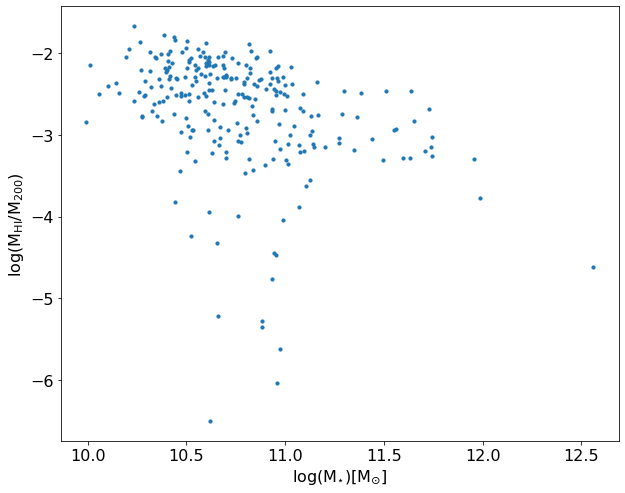

In [17]:
plt.rc('font', size=16)
plt.figure(figsize=(10,8))
plt.scatter(np.log10(smass), np.log10(gmass/dmmass), s=10)
plt.xlabel(r'$\rm log(M_{\star})[M_{\odot}]$')
plt.ylabel(r'$\rm log(M_{\rm HI}/M_{\rm 200})$');

# Method 2: compute HI masses
## (using subhaloes total mass and gas metal fraction [preliminary!])

#### 2.1 selecting central and satellite subhaloes
##### `cen` = central, `sat` = satellite

In [14]:
cen_sub = halos['GroupFirstSub']
cen_ids = cen_sub[cen_sub>=0] ### IDs of the central subhaloes (-1 means the halo has no subhalo so we exclude those)
cen_gn = subhalos['SubhaloGrNr'][cen_ids]  ### Parent halo IDs of the central subhaloes
mask = np.zeros(subhalos['count'], dtype=bool)
mask[cen_ids] = True
all_sub_ids = np.arange(subhalos['count'])
sat_ids = all_sub_ids[~mask]
sat_gn = subhalos['SubhaloGrNr'][sat_ids]
sat_flag = subhalos['SubhaloFlag'][sat_ids]
print('Number of central subhaloes: %d\nNumber of satellite subhaloes: %d\nNumber of flagged subhaloes (non-cosmological origin): %d' \
      %(cen_ids.size,sat_flag[sat_flag==True].size,sat_flag[sat_flag==False].size))

Number of central subhaloes: 4462345
Number of satellite subhaloes: 1224424
Number of flagged subhaloes (non-cosmological origin): 1344


In [21]:
x = np.take(cen_gn, id_j)
x.size

7904

#### Method 2.1: extracting HI masses from h1h2 catalog

##### 2.2.1 masses of central subhaloes

In [13]:
mhalo_cen = halos['Group_M_Mean200'][cen_gn] * 1e10/h
msub_cen = subhalos['SubhaloMassInRadType'][cen_ids] * 1e10/h
gas_frac_cen = subhalos['SubhaloGasMetalFractions'][cen_ids]

In [14]:
halo_mass_min = 10**halo_min_log
print('Number of galaxies that match the halo mass criteria: %d' %mhalo_cen[mhalo_cen>halo_mass_min].size)

Number of galaxies that match the halo mass criteria: 271


##### 2.2.2 masses of satellite subhaloes

In [15]:
mhalo_sat = halos['Group_M_Mean200'][sat_gn] * 1e10/h
msub_sat = subhalos['SubhaloMassInRadType'][sat_ids] * 1e10/h
gas_frac_sat = subhalos['SubhaloGasMetalFractions'][sat_ids]

### Discarding the flagged subhaloes
mhalo_sat = mhalo_sat[sat_flag]
msub_sat = msub_sat[sat_flag]
gas_frac_sat = gas_frac_sat[sat_flag]

#### 2.3 applying halo mass selection criteria

In [16]:
### On central subhaloes
m200_cen = mhalo_cen[mhalo_cen>halo_mass_min]
mgal_cen = msub_cen[mhalo_cen>halo_mass_min]
gfrac_cen = gas_frac_cen[mhalo_cen>halo_mass_min]

### On satellite subhaloes
m200_sat = mhalo_sat[mhalo_sat>halo_mass_min]
mgal_sat = msub_sat[mhalo_sat>halo_mass_min]
gfrac_sat = gas_frac_sat[mhalo_sat>halo_mass_min]

#### 2.4 deriving the HI mass from the gas mass
##### (MHI = H_fraction * Mgas)

In [17]:
### For central subhaloes
mgas_cen, mstar_cen = mgal_cen[:,0], mgal_cen[:,4]
mhi_cen = gfrac_cen[:,0] * mgas_cen

### For satellite subhaloes
mgas_sat, mstar_sat = mgal_sat[:,0], mgal_sat[:,4]
mhi_sat = gfrac_sat[:,0] * mgas_sat

###### Note from simulation regarding gas metal fractions: H, He, C, N, O, Ne, Mg, Si, Fe, total (in this order). Each is the dimensionless ratio of the total mass in that species divided by the total gas mass, both restricted to gas cells within twice the stellar half mass radius. The tenth entry contains the 'total' of all other (i.e. untracked) metals.

#### 2.5 plotting results

<ipython-input-18-05f195f78253>:3: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(mstar_cen),np.log10(mhi_cen/m200_cen), s=10, color='k', label='central')
<ipython-input-18-05f195f78253>:4: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(mstar_sat),np.log10(mhi_sat/m200_sat), s=10, color='gray', alpha=0.3, label='satellite')


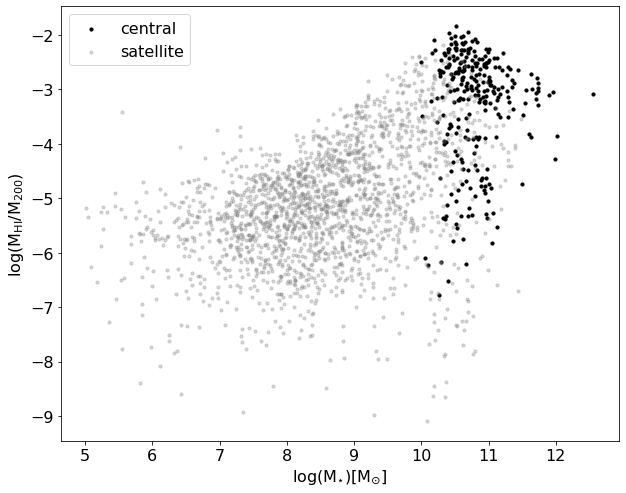

In [18]:
plt.rc('font', size=16)
plt.figure(figsize=(10,8))
plt.scatter(np.log10(mstar_cen),np.log10(mhi_cen/m200_cen), s=10, color='k', label='central')
plt.scatter(np.log10(mstar_sat),np.log10(mhi_sat/m200_sat), s=10, color='gray', alpha=0.3, label='satellite')
plt.xlabel(r'$\rm log(M_{\star})[M_{\odot}]$')
plt.ylabel(r'$\rm log(M_{\rm HI}/M_{\rm 200})$')
plt.legend(loc='best')
plt.show();

# 3. Comparing the two results

#### Compare the number of objects in each plot above (excluding the infinit log masses and mass ratios)

In [19]:
warnings.filterwarnings('ignore')
x_h1h2 = np.log10(smass); y_h1h2 = np.log10(gmass/dmmass)
mask_h1h2 = np.logical_or(np.isinf(x_h1h2), np.isinf(y_h1h2))
x_h1h2 = x_h1h2[~mask_h1h2]; y_h1h2 = y_h1h2[~mask_h1h2]

x_frac = np.log10(mstar_cen); y_frac = np.log10(mhi_cen/m200_cen)
mask_frac = np.logical_or(np.isinf(x_frac), np.isinf(y_frac))
x_frac = x_frac[~mask_frac]; y_frac = y_frac[~mask_frac]

print('Number of subhaloes in Method 1 plot: %d\nNumber of subhaloes in Method 2 plot: %d' %(x_h1h2.size,x_frac.size))

Number of subhaloes in Method 1 plot: 271
Number of subhaloes in Method 2 plot: 270


#### Overlaying the above two plots

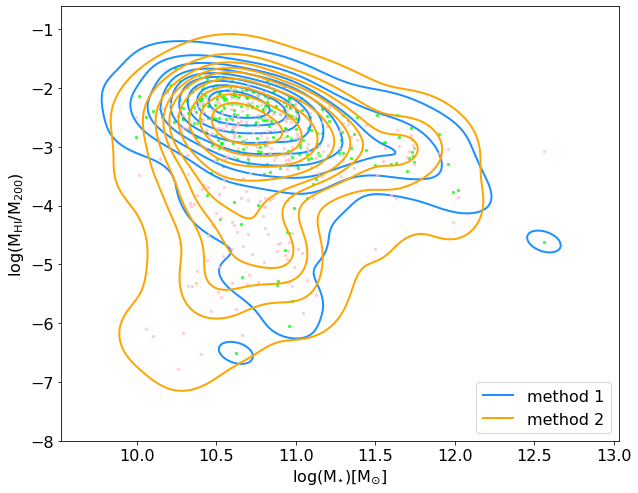

In [20]:
plt.rc('font', size=16)
fig, ax = plt.subplots(figsize=(10,8))

### Plot method 1 data (centrals)
plt.scatter(x_h1h2, y_h1h2, s=5, color='lime', alpha=0.7)
sns.kdeplot(x=x_h1h2, y=y_h1h2, ax=ax, fill=False, color='dodgerblue', levels=10, linewidths=2, thresh=0.02, zorder=1, label='method 1')

### Plot method 2 data (centrals)
plt.scatter(x_frac, y_frac, s=5, color='pink', alpha=0.7)
sns.kdeplot(x=x_frac,y=y_frac, ax=ax, fill=False, color='orange', levels=10, linewidths=2, thresh=0.02, zorder=2, label='method 2')
plt.xlabel(r'$\rm log(M_{\star})[M_{\odot}]$')
plt.ylabel(r'$\rm log(M_{\rm HI}/M_{\rm 200})$')
plt.legend(loc='lower right')
plt.show();